# Init libraries

In [76]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageNet
from torchvision.transforms import ToTensor,Grayscale,Compose,RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, Resize, functional
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import time as time
import numpy as np
from IPython import display

# Load Dataset and convert to grayscale

In [77]:
# Dataset class for the ImageNet dataset extending the torchvision ImageNet class
class ImageNetDataset(ImageNet):
    # Constructor
    def __init__(self, root, split='train', transform=None):
        # Calling the constructor of the parent class
        super().__init__(root, split=split, transform=transform)
        

    # Getting the image and label at a given index
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        return image, label

    # Getting the length of the dataset
    def __len__(self):
        return super().__len__()
    

In [78]:
# Define transforms
#Train transforms
train_transform = Compose([
    ToTensor(),
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    Grayscale(num_output_channels=1),
    Resize((256, 256))
])
#Test transforms
val_transform = Compose([
    ToTensor(),
    Grayscale(num_output_channels=1),
    Resize((256, 256))
])
# Data loaders
root="./dataset/imagenet/"
train_dataset = ImageNetDataset(root, split='train', transform=train_transform)
val_dataset = ImageNetDataset(root, split='val', transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

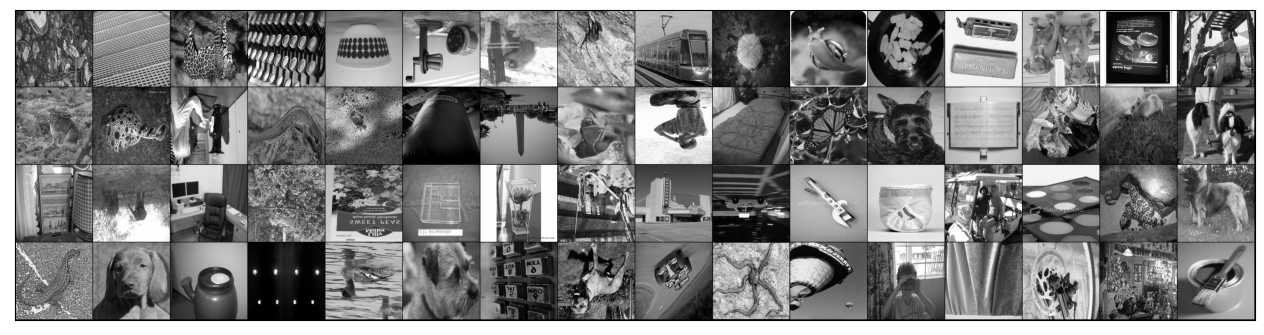

In [79]:
# Function to show a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_loader)

# UNET Autoencoder
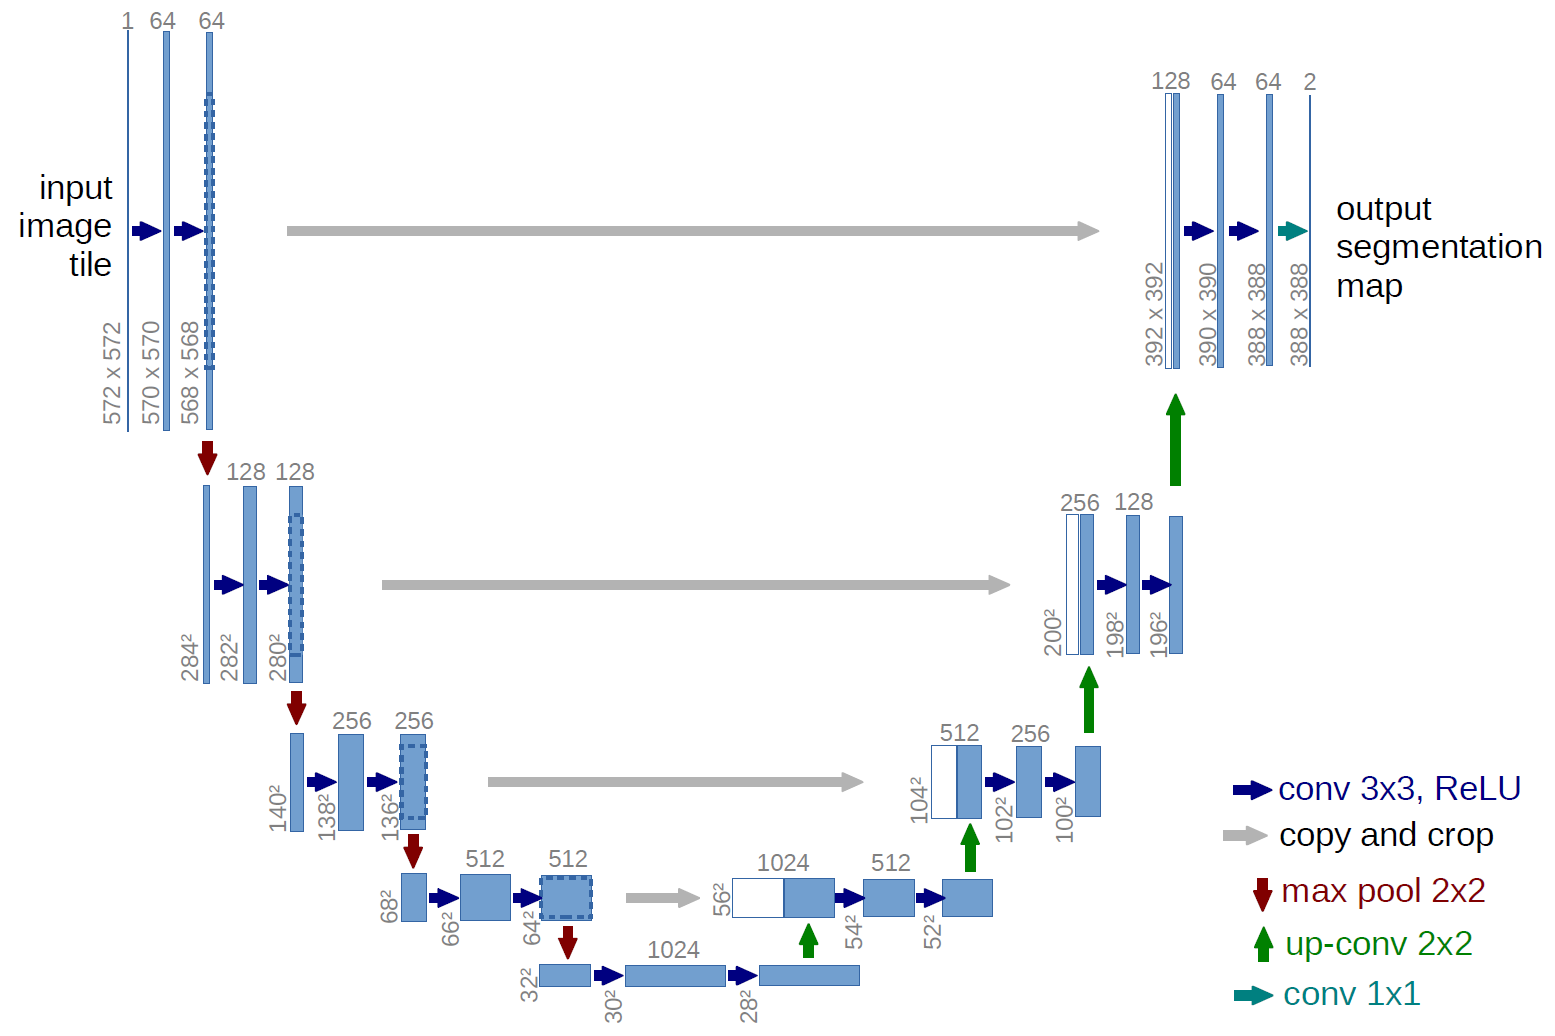

In [80]:
# Implement UNet autoencoder
class UNet(nn.Module):
    # Constructor of the class 
    # Params:
    # self=self
    # in_channels= input image channels since in our case we are using grayscale images this is 1
    # out_channels= outpute image channels since we are using grayscale images this is 1
    # featuress= list of numbers of output features for each block of the net (layer before max pooling)
    # By default features are initialized like in the paper #
    def __init__(self, in_channels=1, out_channels=1,features=[64, 128, 256, 512]):
        super(UNet,self).__init__()
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder part of the network
        # Iterate over the features list and create a double convolution block for each feature
        # after each iteration in_channels = feature since the next block in_channel is equals to the previous block output features
        # the bottom layer of the network is added later on#
        for feature in features:
            self.encoder_blocks.append(UNet.double_convolution(in_channels, feature))
            in_channels = feature
            # Maxpool not applied here because we need to save the output of the encoder block for the skip connection in the decoder part of the network
            
            
        # Decoder part of the network 
        # Iterate through the feature backwards (from the bottom to top of the image) #
        for feature in reversed(features):
            # Upconv part of the decoder block
            self.decoder_blocks.append(
                # feature * 2 because the decoder block has 2 inputs 
                # (the output of the encoder block with skip connection and the output of the maxpooling of the previous decoder block)
                # kernel_size=2 and stride=2 upsample the image doubling width and height
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
                )
            # Double convolution part of the decoder block 
            self.decoder_blocks.append(UNet.double_convolution(feature*2, feature))
        # Bottom layer of encoder/decoder part of the network
        # this layer is the last encoder block and first decoder block and as before uses doube convolution #
        self.bottom_layer = UNet.double_convolution(features[-1], features[-1]*2)
        # Final convolution layer of decoder part of the network 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    # Double convolution block utility function since both encoder and decoder have a double convolution for each block#
    def double_convolution(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            # In the 2015 paper there was no batch normalization but it should be ok to add it
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    # Forward function of the network
    # Params:
    # self=self
    # x= input image
    def forward(self, x):
        # Store the skip connections for the decoder part of the network
        skip_connections = []
        # Encoder part of the network
        # Iterate over the encoder blocks and apply them to the input image
        # add x to the skip_connections list and then apply maxpool to x
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.maxpool(x)
        
        # Bottom layer of the network
        # Apply the bottom layer to the output of the last encoder block
        x = self.bottom_layer(x)
        # Decoder part of the network
        # Reverse the skip connections list to iterate from the bottom layer to the top one (List have been created from top to bottom)
        skip_connections = skip_connections[::-1]
        # Iterate over the decoder blocks and apply them to the input image
        # The starting index is 0 and the step is 2 because the decoder blocks list has 2 blocks for each layer (upconv and double convolution)
        for i in range(0, len(self.decoder_blocks), 2):
            # Get the skip connection for the current layer
            skip_connection = skip_connections[i//2]
            # Apply the upconv block to the input image
            x = self.decoder_blocks[i](x)

            # Check if the output of the upconv block and the skip connection have the same size
            # If not crop the skip connection to the size of the output of the upconv block
            # In our use case should not be necessary since we resized images to 256x256 in the dataloader
            if x.shape != skip_connection.shape:
                skip_connection = functional.interpolate(skip_connection, size=x.shape[2:])

            # Concatenate the output of the upconv block and the skip connection
            x = torch.cat((skip_connection, x), dim=1)
            # Apply the double convolution block to the concatenated image
            x = self.decoder_blocks[i+1](x)
        
        # Final convolution layer of the network
        return self.final_conv(x)




## Quick test to see if the model returns an image with the same shape than the original one

In [81]:
### Set the random seed for reproducible results
torch.manual_seed(0)
x = train_dataset[0][0].unsqueeze(0)
model = UNet()
preds = model(x)
print(preds.shape)
assert preds.shape == x.shape



torch.Size([1, 1, 256, 256])
